In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle

In [25]:
# === Config ===
SEQ_LEN = 20
EPOCHS = 30
BATCH_SIZE = 32
LR = 0.001
INPUT_FEATURES = ['x', 'y', 'lin_vel', 'ang_vel', 'cmd_lin_x', 'cmd_ang_z']
TARGET_FEATURES = ['x', 'y']

In [26]:
# === Step 1: Load CSV & Normalize ===
df = pd.read_csv("aligned_data.csv")
scaler = MinMaxScaler()
scaled_inputs = scaler.fit_transform(df[INPUT_FEATURES])

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [27]:
df.head()

,time,x,y,lin_vel,ang_vel,cmd_lin_x,cmd_ang_z
0,1.746638e+09,-0.483882,-0.500002,0.150002,-2.884031e-08,0.15,0.0
1,1.746638e+09,-0.478782,-0.500002,0.150004,-8.847759e-10,0.15,0.0
2,1.746638e+09,-0.453281,-0.500002,0.150001,-4.012190e-08,0.15,0.0
3,1.746638e+09,-0.422682,-0.500002,0.150004,-1.100738e-07,0.15,0.0
4,1.746638e+09,-0.417581,-0.500002,0.150005,-1.172784e-07,0.15,0.0


In [28]:
# === Step 2: Dataset ===
class TrajectoryDataset(Dataset):
    def __init__(self, inputs, raw_df, seq_len):
        self.inputs = inputs
        self.targets = raw_df
        self.seq_len = seq_len

    def __len__(self):
        return len(self.inputs) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.inputs[idx:idx + self.seq_len]
        y = self.targets.iloc[idx + self.seq_len][TARGET_FEATURES].values
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = TrajectoryDataset(scaled_inputs, df, SEQ_LEN)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [29]:
# === Step 3: BiLSTM ===
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model = BiLSTM(input_size=len(INPUT_FEATURES))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [30]:
# === Step 4: Train & Track Loss ===
loss_history = []
predicted_xy = []
true_xy = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in loader:
        pred = model(batch_x)
        loss = criterion(pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if epoch == EPOCHS - 1:
            predicted_xy.extend(pred.detach().numpy())
            true_xy.extend(batch_y.detach().numpy())

    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")


Epoch 1/30 | Loss: 0.7070
Epoch 2/30 | Loss: 0.0225
Epoch 3/30 | Loss: 0.0091
Epoch 4/30 | Loss: 0.0074
Epoch 5/30 | Loss: 0.0055
Epoch 6/30 | Loss: 0.0053
Epoch 7/30 | Loss: 0.0046
Epoch 8/30 | Loss: 0.0037
Epoch 9/30 | Loss: 0.0035
Epoch 10/30 | Loss: 0.0031
Epoch 11/30 | Loss: 0.0029
Epoch 12/30 | Loss: 0.0034
Epoch 13/30 | Loss: 0.0024
Epoch 14/30 | Loss: 0.0019
Epoch 15/30 | Loss: 0.0018
Epoch 16/30 | Loss: 0.0016
Epoch 17/30 | Loss: 0.0016
Epoch 18/30 | Loss: 0.0014
Epoch 19/30 | Loss: 0.0011
Epoch 20/30 | Loss: 0.0012
Epoch 21/30 | Loss: 0.0010
Epoch 22/30 | Loss: 0.0013
Epoch 23/30 | Loss: 0.0010
Epoch 24/30 | Loss: 0.0010
Epoch 25/30 | Loss: 0.0007
Epoch 26/30 | Loss: 0.0007
Epoch 27/30 | Loss: 0.0005
Epoch 28/30 | Loss: 0.0007
Epoch 29/30 | Loss: 0.0007
Epoch 30/30 | Loss: 0.0007


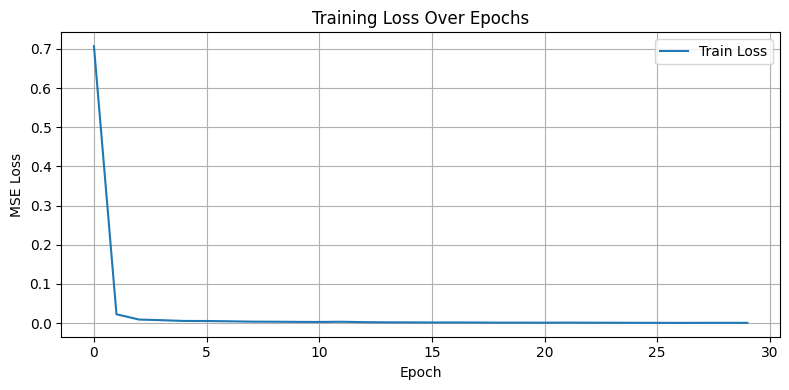

In [34]:
# === Step 5: Plot Loss Curve ===
plt.figure(figsize=(8,4))
plt.plot(loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

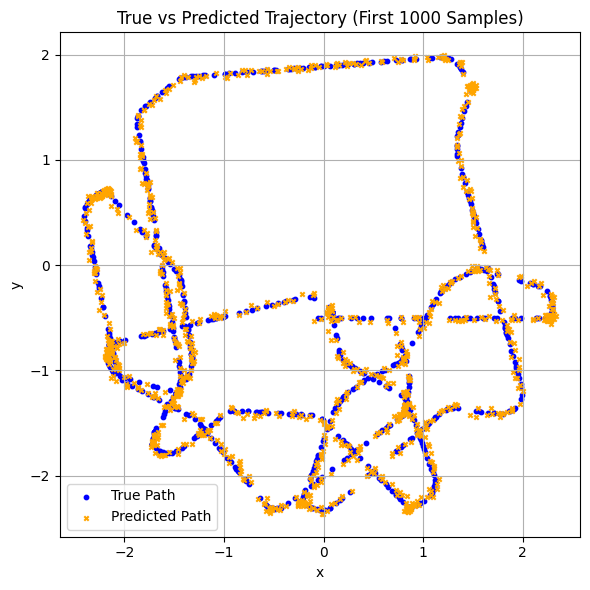

In [38]:
# === NEW: Simplified Path Visualization ===

# Convert to arrays
predicted_xy = np.array(predicted_xy)
true_xy = np.array(true_xy)

# Pick the first 100 predictions for clarity
N = 1000

plt.figure(figsize=(6, 6))
plt.scatter(true_xy[:N, 0], true_xy[:N, 1], label="True Path", color='blue', s=10)
plt.scatter(predicted_xy[:N, 0], predicted_xy[:N, 1], label="Predicted Path", color='orange', s=10, marker='x')

plt.xlabel("x")
plt.ylabel("y")
plt.title(f"True vs Predicted Trajectory (First {N} Samples)-lstm approach")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("simplified_trajectory_comparison.png")
plt.show()


In [39]:
# === Step 6: Save Model ===
torch.save(model.state_dict(), "bilstm_model.pt")
print("✅ Model saved as bilstm_model.pt")

✅ Model saved as bilstm_model.pt


✅ GIF saved as 'trajectory_prediction.gif'


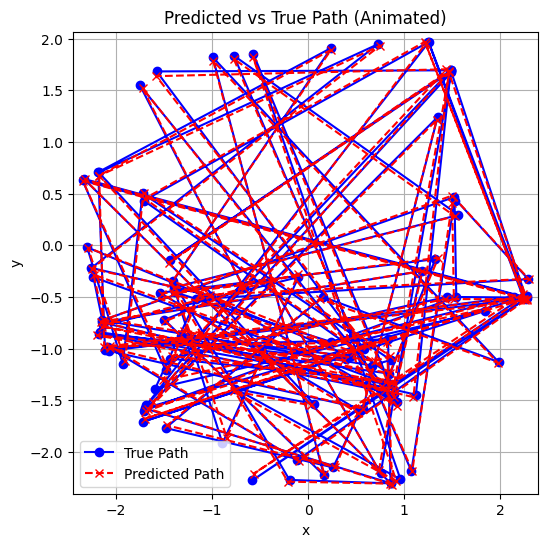

In [40]:
import matplotlib.animation as animation

# Limit to first N points for clarity
N = 100
true_xy = np.array(true_xy)[:N]
predicted_xy = np.array(predicted_xy)[:N]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(np.min(true_xy[:, 0]) - 0.1, np.max(true_xy[:, 0]) + 0.1)
ax.set_ylim(np.min(true_xy[:, 1]) - 0.1, np.max(true_xy[:, 1]) + 0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Predicted vs True Path (Animated)')
ax.grid(True)

true_line, = ax.plot([], [], 'bo-', label='True Path')
pred_line, = ax.plot([], [], 'rx--', label='Predicted Path')
ax.legend()

def init():
    true_line.set_data([], [])
    pred_line.set_data([], [])
    return true_line, pred_line

def update(frame):
    true_line.set_data(true_xy[:frame, 0], true_xy[:frame, 1])
    pred_line.set_data(predicted_xy[:frame, 0], predicted_xy[:frame, 1])
    return true_line, pred_line

ani = animation.FuncAnimation(fig, update, frames=N, init_func=init, blit=True, repeat=False)

# Save GIF
ani.save("trajectory_prediction.gif", writer="pillow", fps=10)
print("✅ GIF saved as 'trajectory_prediction.gif'")
